# **Model Comparison**
----

## Goals of this notebook:

1. Compare different agents with different hyperparametrization
---
## Library imports

#### 1. RL libraries:

In [1]:
import environments
from agents.agents import TDLambdaPredictor, WatkinsLambda, Sarsa,\
                          QLearning, SarsaLambda, MonteCarloPredictor,\
                          MontecarloController, OffPolicyMontecarlo

#### 2. Data aggregation and matrix operation libraries:

In [2]:
import numpy as np
import pandas as pd

#### 3. Plotting libraries:

In [3]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.colors import ListedColormap, BoundaryNorm
from matplotlib.ticker import FormatStrFormatter, ScalarFormatter, FuncFormatter
import seaborn as sns
# Commands to tweak notebook layout:
from sys import maxsize
np.set_printoptions(threshold=maxsize)
plt.style.use('seaborn-pastel')

#### 4. Parallel programming:

In [4]:
import multiprocessing as mp

----

## Common plotting utilities:

#### Average reward time series:

In [5]:
def plot_reward_time_series(X,Y, far=True, lower=None, upper=None):
    """
    X: a range of numbers starting from the sample size number to the total number of episode + 1
       (to make it inclusive) and incrementing by sample size steps.
    Y: average rewards
    far: bool. If False the plots zooms in.
    lower: the lower bound of average rewards. Same length than Y.
    upper: the upper bound of average rewards. Same length than Y.
    
    returns: the plot container instance
    """
    # domain redefinition to adjust how many x-ticks are displayed dinamically
    max_domain = X[-1]
    multiplier = len(str(max_domain)) - 2
    step = int(str(max_domain)[0]) * 10**multiplier
    domain = np.arange(X[0], max_domain + step, step)
    
    if far:
        ylim = (-1, 1)
        yticks= np.arange(-1,1.05,0.05)
    else:
        max_value = max(0, max(Y))
        ylim = (min(Y)-0.1, max_value)
        yticks = np.round(np.arange(min(Y)-0.1, max_value+0.1, 0.01),2)
    
    fig = plt.figure(figsize=(20,10))
    
    style_dict = {'xlim': (X[0], max_domain),
                  'xticks': domain,
                  'xticklabels': domain,
                  'xlabel': 'Episodes',
                  'ylim': ylim,
                  'yticks': yticks,
                  'yticklabels': yticks,
                  'title': 'Average reward over last {0:,.0f} episodes'.format(X[0])
                 }
    
    ax = fig.add_subplot(1,1,1, **style_dict)
    ax.grid()
    #Axis formatters:
    formatter = ScalarFormatter(useMathText=True)
    #Scientific value display when the total number of episodes is over 1M:
    formatter.set_scientific(True)
    ax.xaxis.set_major_formatter(formatter)
    ax.yaxis.set_major_formatter(FormatStrFormatter('% 1.2f'))
    # in and out of the money border:
    ax.plot(domain.ravel(), np.zeros_like(domain).ravel(), color='red')
    
    #if bounds of ci are passed as arguments, plot them:
    if lower and upper:
        ax.fill_between(X, lower, upper, alpha=0.1, color='green')
    
    ax.plot(X,Y)
    
    return ax

#### Density plot:

In [6]:
def plot_density(data):
    """
    data: a Panda Series containing every sample of average rewards
    
    returns: both histogram and boxplot container instances
    """
    title = 'Average reward sampling: $\overline{{X}}$={0:.2f}, s={1:.2f}, n={2:,.0f}, num of samples={3:,.0f}'\
            .format(data.mean(),
                    data.std(),
                    data.index.values[0],
                    len(data))
    
    fig, (ax_box, ax_hist) = plt.subplots(2, sharex=True, figsize=(20,10), gridspec_kw={"height_ratios": (.15, .85)}) 
    fig.suptitle(t=title, fontsize=16, x=0.5, y=1.05)
    
    sns.boxplot(data=data,x=data, ax=ax_box)
    sns.histplot(data=data, x=data, ax=ax_hist, bins=20, kde=True)
    
    #Delimiting tails:
    ax_hist.axvline(x=np.percentile(data,[2.5]), label='2.5th percentile', c='r')
    ax_hist.axvline(x=np.percentile(data,[97.5]), label='97.5th percentile', c='r')
    ax_hist.legend()
    ax_hist.set_xlabel('Average Reward')
    
    return ax_box, ax_hist

#### Value Function:

In [7]:
def plot_v_func(table, title):
    """
    table: agent's V-table (if agents has a Q-table, it must be transformed before being passed as an argument for this function)
    title: str. A title for the plot
    
    returns: the plot container instance
    """
    X = np.linspace(1,10,10)
    Y = np.linspace(12, 20,9)
    Xm, Ym = np.meshgrid(X, Y)
    
    fig = plt.figure(figsize=(20,10))
    fig.suptitle(t=title, fontsize=16, x=0.5, y=1.05)
    
    common_style_dict = {'xlim': (X[0], X[-1]),
                        'xticks': X,
                        'xticklabels': ['{:.0f}'.format(value) for value in list(X)[1:]] + ['A'],
                        'xlabel': 'Dealer\'s Card',
                        'ylim': (Y[0], Y[-1]),
                        'yticks': Y,
                        'yticklabels': Y,
                         'ylabel': 'Player\'s Total',
                        'zlim': (-1, 1.5),
                        'zticks': np.arange(-1, 1.8, 0.2),
                        'zticklabels': np.arange(-1, 1.8, 0.2),
                        }
    
    #Not usable ace-related states:
    ax = fig.add_subplot(1,2,1, projection='3d', title='No usable Ace', **common_style_dict)
    surface_1 = ax.plot_surface(Xm, Ym, table[8:17,:10,0], cmap=plt.get_cmap('bwr'), vmin=-1, vmax=1)
    
    ax.yaxis.set_major_formatter(FormatStrFormatter('% 1.0f'))
    ax.zaxis.set_major_formatter(FormatStrFormatter('% 1.1f'))
    ax.view_init(ax.elev, -120)
    
    #Usable ace-related states:
    ax = fig.add_subplot(1,2,2, projection='3d', title=' Usable Ace', **common_style_dict)
    surface_2 = ax.plot_surface(Xm, Ym, table[8:17,:10,1], cmap=plt.get_cmap('bwr'), vmin=-1, vmax=1)
    
    ax.yaxis.set_major_formatter(FormatStrFormatter('% 1.0f'))
    ax.zaxis.set_major_formatter(FormatStrFormatter('% 1.1f'))
    ax.view_init(ax.elev, -120)
    
    #Colour bar:
    fig.subplots_adjust(right=0.8)
    cbar_ax = fig.add_axes([0.85, 0.35, 0.01, 0.5])
    fig.colorbar(surface_1,shrink=0.2, aspect=15, cax=cbar_ax)
    
    return ax

#### Policy:

In [8]:
def plot_policy(table, title):
    """
    table: matrix containing action indexes (it must have n-1 dimensions with respect to the agent's Q-table)
    title: str. A title for the plot
    
    returns: the plot container instance
    """
    #tick label transformer (used for the colour bar):
    def format_tick(x, pos):
        if x == 0:
            return '{0}-STAND'.format(str(x))
        elif x == 1:
            return '{0}-HIT'.format(str(x))
    
    X = np.arange(-.5,9.5,1)
    Y = np.arange(0.5, 11.5,1)
    
    fig = plt.figure(figsize=(20,10))
    fig.suptitle(t=title, fontsize=16, x=0.5, y=1.05)
    
    common_style_dict = {'xlim': (-.5, 9.5),
                        'xticks': X,
                        'xticklabels': ['{:.0f}'.format(value) for value in range(2,11,1)] + ['A'],
                        'xlabel': 'Dealer\'s Card',
                        'yticks': Y,
                        'yticklabels': np.arange(11,22,1),
                        'ylabel': 'Player\'s Total'
                        }
    #I only plot those states wherein there is risk of going bust after hitting once more and, for the sake of symmetry,
    #I manually modify those non-existing usable-ace-related states:
    table[:8,:,1] = 1
    
    #Not usable ace-related states:
    ax = fig.add_subplot(1,2,1, title='No usable Ace', **common_style_dict)
    im = ax.imshow(table[7:18,:10,0], cmap=plt.get_cmap('bwr'), vmin=0, vmax=1, alpha=0.5)
    ax.invert_yaxis()
    ax.grid(True,color='w', linestyle='-', linewidth=1, axis='both')
    ##Little tweak for tick labels' position:
    for label in ax.get_xticklabels():
        label.set_horizontalalignment('left')

    for label in ax.get_yticklabels():
        label.set_verticalalignment('top')
    
    #Usable ace-related states:
    ax = fig.add_subplot(1,2,2, title=' Usable Ace', **common_style_dict)
    ax.imshow(table[7:18,:10,1],cmap=plt.get_cmap('bwr'), vmin=0, vmax=1, alpha=0.5)
    ax.invert_yaxis()
    ax.grid(True,color='w', linestyle='-', linewidth=1, axis='both')
    ##Little tweak for tick labels' position:
    for label in ax.get_xticklabels():
        label.set_horizontalalignment('left')
    
    #Colour bar definition
    fig.subplots_adjust(right=0.8)
    original_cmap = plt.get_cmap('bwr')
    
    #Converting a multiple-colour cmap into 2-colour cmap
    cmap = ListedColormap([original_cmap(0), original_cmap(original_cmap.N)])
    bounds = [0, 0.5, 1]
    norm = BoundaryNorm(bounds, original_cmap.N)    
    cbar_ax = fig.add_axes([0.85, 0.05, 0.01, 0.85])
    
    fig.colorbar(cm.ScalarMappable(cmap=cmap, norm=norm),
                 shrink=0.2,
                 aspect=15,
                 cax=cbar_ax,
                 boundaries= [0] + bounds + [2],  
                 extend='both',
                 ticks=[0,1],
                 format = FuncFormatter(format_tick),
                 spacing='proportional',
                 orientation='vertical',
                 alpha= 0.5)
    
    return ax

----

## Experiment Definition:

#### Montecarlo method:

In [9]:
def run_experiment(env, agent, episodes, show, save=None, collect_rewards=None, train=True):
    """
    env: instance of the environment to execute.
    agent: instance of the agent that will interact with the environment.
    show: integer. It indicates how often episodes are printed as text(it helps track the existence of bugs in the game itself).
    save: integer. It indicates how often the V/Q-table is permanently persisted as a pickle object. None = no persistence at all.
    collect_rewards: It indicates every so many episodes rewards are averaged. 1 = return every reward.
    train: bool. If True, the agent learns by updating its V/Q-table; if False, the agent just executes a defined policy.
    
    returns: a list containing all average rewards computed throughout the whole experiment.
    """
    rewards = []
    average_rewards = []
    for episode in range(episodes):
        if (episode+1) % show ==0:
            print('Episode {0}:'.format(episode+1))
            env.render()

        state, reward, terminal, _ = env.reset()
        while not terminal:
            action = agent.follow_policy(state)
            next_state, reward, terminal, _ = env.step(action)
            if train:
                agent.evaluate_state(state, reward, terminal, action)   
                
            state=next_state
            
        rewards.append(reward)
        
        if save:
            if (episode+1) % save == 0:
                agent.save_table()
                
        if collect_rewards:
            if (episode+1) % collect_rewards == 0:
                average_reward = sum(rewards[-collect_rewards:])/collect_rewards
                average_rewards.append(average_reward)
    
    return average_rewards

#### Temporal Difference methods:

In [10]:
def run_experiment_one_step(env, agent, episodes, show, save=None, collect_rewards=None, train=True):
    """
    environment: instance of the environment to execute.
    agent: instance of the agent that will interact with the environment.
    show: integer. It indicates how often episodes are printed as text(it helps track the existence of bugs in the game itself).
    save: integer. It indicates how often the V/Q-table is permanently persisted as a pickle object. None = no persistence at all.
    collect_rewards: It indicates every so many episodes rewards are averaged. 1 = return every reward.
    train: bool. If True, the agent learns by updating its V/Q-table; if False, the agent just executes a defined policy.
    
    returns: a list containing all average rewards computed throughout the whole experiment.
    """
    rewards = []
    average_rewards = []
    for episode in range(episodes):
        if (episode+1) % show ==0:
            print('Episode {0}:'.format(episode+1))
            env.render()

        state, reward, terminal, _ = env.reset()
        while not terminal:
            action = agent.follow_policy(state)
            next_state, reward, terminal, _ = env.step(action)
            if train:
                agent.evaluate_state(state, reward, terminal, action, next_state)   
                
            state=next_state
            
        rewards.append(reward)
        
        if save:
            if (episode+1) % save == 0:
                agent.save_table()
                
        if collect_rewards:
            if (episode+1) % collect_rewards == 0:
                average_reward = sum(rewards[-collect_rewards:])/collect_rewards
                average_rewards.append(average_reward)
    
    return average_rewards

In [11]:
def run_experiment_sarsa(env, agent, episodes, show, save=None, collect_rewards=None, train=True):
    """
    environment: instance of the environment to execute.
    agent: instance of the agent that will interact with the environment.
    show: integer. It indicates how often episodes are printed as text(it helps track the existence of bugs in the game itself).
    save: integer. It indicates how often the V/Q-table is permanently persisted as a pickle object. None = no persistence at all.
    collect_rewards: It indicates every so many episodes rewards are averaged. 1 = return every reward.
    train: bool. If True, the agent learns by updating its V/Q-table; if False, the agent just executes a defined policy.
    
    returns: a list containing all average rewards computed throughout the whole experiment.
    """
    rewards = []
    average_rewards = []
    for episode in range(episodes):
        if (episode+1) % show ==0:
            print('Episode {0}:'.format(episode+1))
            env.render()

        state, reward, terminal, _ = env.reset()
        next_action = None
        while not terminal:
            if next_action:
                action = next_action
            else:
                action = agent.follow_policy(state)
                
            next_state, reward, terminal, _ = env.step(action)
            if not terminal:
                next_action = agent.follow_policy(next_state)
            else:
                next_action = None
                
            if train:
                agent.evaluate_state(state, reward, terminal, action, next_state, next_action)   
            
            state=next_state
            
        rewards.append(reward)
        
        if save:
            if (episode+1) % save == 0:
                agent.save_table()
                
        if collect_rewards:
            if (episode+1) % collect_rewards == 0:
                average_reward = sum(rewards[-collect_rewards:])/collect_rewards
                average_rewards.append(average_reward)
    
    return average_rewards

#### Wrapper:

In [12]:
agents_methods = {'MonteCarloPredictor': run_experiment,
                  'MontecarloController': run_experiment,
                  'OffPolicyMontecarlo': run_experiment,
                  'TDLambdaPredictor': run_experiment_one_step,
                  'WatkinsLambda': run_experiment_sarsa,
                  'Sarsa': run_experiment_sarsa,
                  'QLearning': run_experiment_one_step,
                  'SarsaLambda': run_experiment_sarsa}

#### Train and test methods:

In [13]:
#subclass for prediction:
class Evaluator(MonteCarloPredictor):
    #greedy policy:
    def follow_policy(self, observation, *args):
        table_look_up = tuple(self.table_look_up(observation))
        action = np.argmax(self.table[table_look_up][:])
        
        return action

In [14]:
def put_q_test(q, agent, episodes, show_every, save_every, collect_every):
    """
    q: Queue from multiprocessing library
    """
    q.put(agents_methods[agent.get_parent_class_str()](env, agent, episodes, show_every, save_every, collect_every, train=False))

def get_q(q):
    """
    q: Queue from multiprocessing library
    
    """
    return q.get()

In [15]:
def train_and_test(env, agent, test_until, test_every, sample_size=8_000, bootstrap_samples=1_000):
    """
    env: rl environmen instance
    agent: control agent instance
    test_until: total number of episodes.
    test_every: indicates how often evaluation is carried out. The agent's table is also saved then.
    sample_size: how many episodes are averaged.
    bootstrap_samples: how many samples of sample_size size are produced to determine the metric's CI.
    
    returns: a dictionary containing results, mean and percentiles for each evaluation
    """
    def test(a):
        """
        Parallelized execution
        a: Prediction agent instance
        
        returns: a dictionary containing the whole list of results,
                 the mean, the 2.5th percentile, and the 97.5 percentile.
        """
        rewards = {'results':[]}
        queue = mp.Manager().Queue()
        cores = mp.cpu_count()
    
        #I split the whole test amongst the computer's cores:
        EPISODES =  sample_size * bootstrap_samples // cores
        SHOW_EVERY = 1_000_000
        SAVE_EVERY =  None
        COLLECT_EVERY = sample_size
        
        # I enqueue every run
        for _ in range(0, cores):
            mp.Process(target=put_q_test, args=(queue, a, EPISODES, SHOW_EVERY, SAVE_EVERY, COLLECT_EVERY,)).start()

        getter = []  
        #I create a pool of workers to handle dequeuing and subsequent execution:
        pool = mp.Pool(cores)
        for _ in range(0, cores):
            getter.append(pool.apply_async(get_q, (queue,)))

        #I extract results from every process and attach them to the dictionary:
        for r in getter:
            rewards['results'].extend(r.get())
        
        #statistics:
        rewards['mean'] = np.array(rewards['results']).mean()
        rewards['lower_bound'] = float(np.percentile(np.array(rewards['results']), [2.5]))
        rewards['upper_bound'] = float(np.percentile(np.array(rewards['results']), [97.5]))
        
        return rewards
            
    summary = {}
    for episodes in range(test_every, test_until + 1, test_every):
        _ = agents_methods[agent.get_parent_class_str()](env, agent, test_every, 1_000_000, None, 1, True)
        #table persistance:
        agent.save_table()
        #Instanciating a brand new prediction agent for each evaluation:
        evaluator = Evaluator(env)
        #Copy the Q-table to be tested:
        evaluator.table = agent.table.copy()
        summary[episodes] = test(evaluator)
        
    return summary

----
## Defining a baseline:

In [16]:
#create an environment instance:
env = environments.make('hitstand')

In [17]:
class BaseLine(MontecarloController):
    
    def follow_policy(self, observation, *args):
        if observation[0] < 19:
            return 0
        else:
            return 1

In [24]:
baseline = BaseLine(env)
baseline.hyperparams

{'discount_rate': 1,
 'learning_rate': None,
 'max_episodes': None,
 'epsilon_start': 1,
 'epsilon_min': 0.05,
 'epsilon_decay': 0.995,
 'ucb_c': 1}

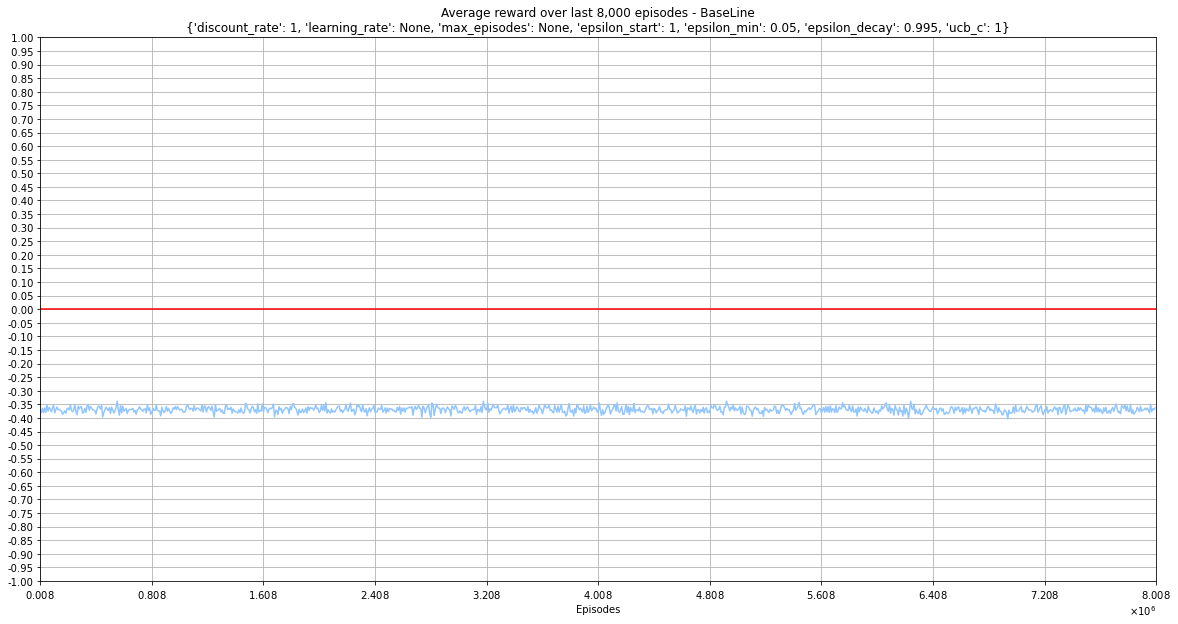

In [26]:
rewards = agents_methods[baseline.get_parent_class_str()](env, baseline, 8_000_000, 1_000_000, save=None, collect_rewards=8_000, train=True)
ax = plot_reward_time_series(range(8_000, 8_000_000+1, 8_000), rewards)
ax.set_title(ax.get_title() + ' - ' + baseline.__class__.__name__ + '\n' + str(baseline.hyperparams));

In [29]:
baseline.save(baseline.num_executed_episodes)
baseline.save_table()

In [30]:
baseline.id

'bca2c1123c5c40b09e49ad96e1858a85'

In [31]:
runs = pd.Series(rewards, index=range(8_000, 8_000_000+1, 8_000))
runs.describe()

count    1000.000000
mean       -0.369432
std         0.010568
min        -0.403313
25%        -0.377141
50%        -0.369875
75%        -0.362172
max        -0.338625
dtype: float64

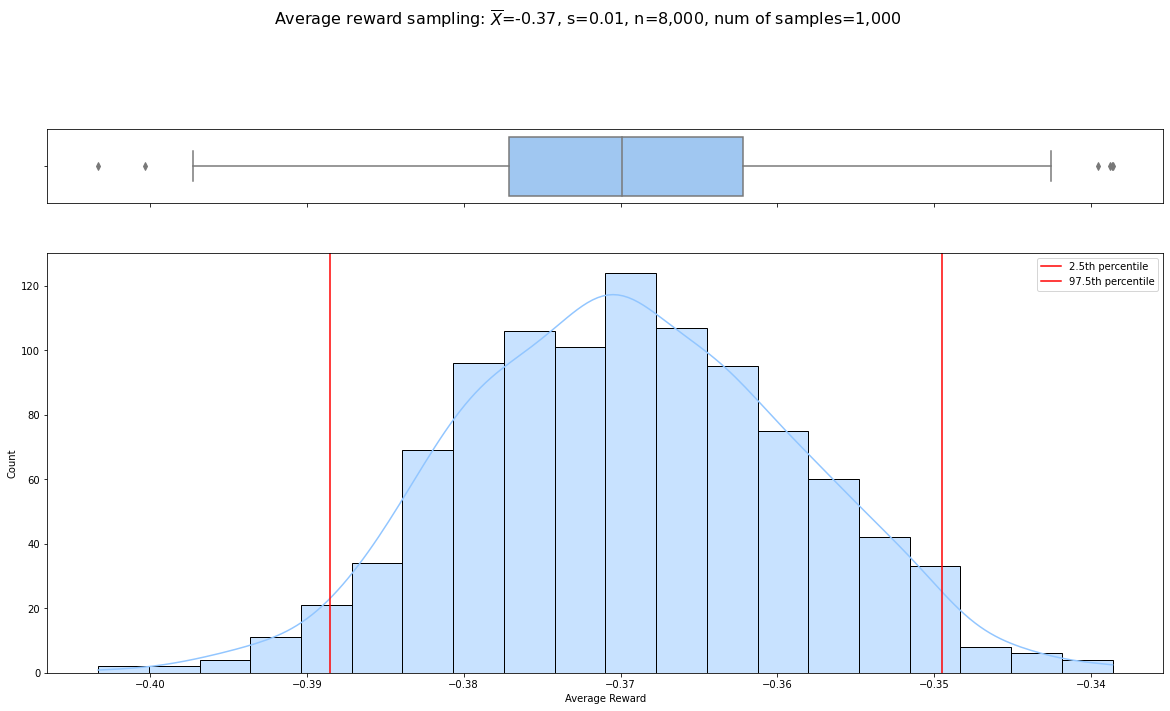

In [32]:
plot_density(runs);

In [35]:
np.percentile(np.array(rewards), 2.5), np.percentile(np.array(rewards), 97.5)

(-0.388525, -0.3494984375)

In [37]:
#Plot V-function